In [63]:
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
import os
import time
import pandas as pd
import asyncio
from playwright.async_api import async_playwright
import nest_asyncio
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
from io import BytesIO
import seaborn as sns  # Optional for better aesthetics

# Patch the event loop for use in Jupyter Notebook
nest_asyncio.apply()


In [ ]:
# Function to get shelter list for a given zip code
async def get_shelter_list(page, zip_code):
    shelters = []

    async def handle_response(response):
        try:
            if 'getShelterListByLatLon' in response.url:
                # Check if response status is 200
                if response.status == 200:
                    shelters_html = await response.text()
                    
                    # Extract shelter IDs and names using regex
                    shelters_data = re.findall(r'<tr id="(\w+)"[^>]*?>.*?<td>(.*?)</td>', shelters_html, re.DOTALL)
                    for shelter_id, shelter_name in shelters_data:
                        shelters.append({
                            'ZIP': zip_code,
                            'ShelterCode': shelter_id,
                            'ShelterName': shelter_name.strip()
                        })
                else:
                    print(f"Received non-200 status code {response.status} for URL {response.url}")
        except Exception as e:
            print(f"Error processing response for {zip_code}: {e}")

    page.on('response', handle_response)

    try:
        await page.goto('https://24petconnect.com/', timeout=60000)
        await page.fill('input[id="zipPostalCodeSearch"]', zip_code)
        await page.click('button[id="changeLocationBtn"]')
        await page.wait_for_timeout(5000)
    except Exception as e:
        print(f"Error during navigation or waiting: {e}")

    return shelters

# Function to process zip codes and write results to CSV
async def process_zip_codes(zip_df):
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        results = []

        total_zip_codes = len(zip_df)

        for i, zip_code in enumerate(zip_df, start=1):
            try:
                print(f"Processing zip code {zip_code} ({i}/{total_zip_codes})")
                shelters = await get_shelter_list(page, zip_code)
                results.extend(shelters)
            except Exception as e:
                print(f"Error processing zip code {zip_code}: {e}")

        await browser.close()
        
        # Convert results to DataFrame and save to CSV
        results_df = pd.DataFrame(results)
        results_df.to_csv('nmshelters.csv', index=False)
        print(f"Results saved to nmshelters.csv")

# Main function to run the processing
async def main():
    zip_data = pd.read_csv('nm_zip_codes.txt', dtype={'ZIP': str})
    zip_df = zip_data['ZIP'].tolist()
    await process_zip_codes(zip_df)

# Run the asyncio event loop in Jupyter Notebook
if __name__ == "__main__":
    nest_asyncio.apply()
    asyncio.run(main())

In [ ]:
# Read the CSV file into a DataFrame
df = pd.read_csv('nmshelters.csv')

# Drop duplicate rows based on ShelterCode and ShelterName
df_cleaned = df.drop_duplicates(subset=['ShelterCode', 'ShelterName'])

# Save the cleaned DataFrame back to a CSV file
df_cleaned.to_csv('nmshelters_cleaned.csv', index=False)

print(f"Duplicates dropped and cleaned data saved to nmshelters_cleaned.csv")

In [18]:
# Function to fetch a webpage with retry mechanism
def fetch_page(url, retries=1):
    """Fetch a webpage with retry mechanism."""
    for attempt in range(retries):
        try:
            response = requests.get(url)
            if response.status_code == 200:
                return response
            else:
                print(f"Unexpected status code {response.status_code} for URL: {url}")
        except requests.RequestException as e:
            print(f"Request failed: {e}. Retrying ({attempt + 1}/{retries})...")
        time.sleep(5)
    print(f"Failed to fetch {url} after {retries} retries.")
    return None

# Function to scrape data for a given ShelterCode
def scrape_shelter_data(shelter_code):
    # Base URL of the webpage to scrape
    base_url = f"https://24petconnect.com/{shelter_code}?at=DOG"
    
    # List to hold all dogs data
    all_dogs = []
    page_num = 0
    
    while True:
        # Construct the URL for the current page
        url = f"{base_url}&index={page_num * 30}" if page_num > 0 else base_url
        
        # Fetch the page
        response = fetch_page(url)
        if not response:
            break
        
        # Parse the webpage content
        soup = BeautifulSoup(response.content, "html.parser")
        
        # Find the relevant section containing dog information
        dogs_section = soup.find("div", {"id": "indexFeaturedAnimals"})
        
        if not dogs_section:
            print(f"Page {page_num + 1} is empty or does not exist. Stopping.")
            break
        
        # Extract data about each dog
        dogs = dogs_section.find_all("div", class_="gridResult")
        
        if len(dogs) < 30:
            print(f"Page {page_num + 1} has fewer than 30 dogs. Moving to the next shelter.")
            break
        
        if not dogs:
            print(f"Page {page_num + 1} is empty. Stopping.")
            break
        
        print(f"Scraping page {page_num + 1}: {len(dogs)} dogs found.")
        
        for dog in dogs:
            # Extract the name
            full_name = dog.find("span", class_="text_Name").text.strip() if dog.find("span", class_="text_Name") else "N/A"
            
            # Extract the name and number
            match = re.match(r"^(.*?)(?:\s*\((A\d+)\))?$", full_name)
            if match:
                name = match.group(1).strip().title() if match.group(1) else "N/A"
                number = match.group(2) if match.group(2) else "N/A"
            
            # Handle case where number is in the format A###### and might be embedded in name
            if number == "N/A":
                match = re.search(r"(A\d+)", full_name)
                if match:
                    number = match.group(1)
                    name = full_name.replace(number, "").strip().title()
            
            # Extract the onclick attribute to build the Pet URL
            onclick_text = dog.get("onclick", "")
            match = re.search(r"Details\('([^']+)', '([^']+)', '([^']+)'\)", onclick_text)
            if match:
                base_path = match.group(1)
                shelter_code = match.group(2)
                number = match.group(3)
                pet_url = f"https://24petconnect.com/{base_path}/Details/{shelter_code}/{number}"
            else:
                pet_url = "N/A"
                
            # Extract other details
            gender_info = dog.find("span", class_="text_Gender").text.strip() if dog.find("span", "text_Gender") else "N/A"
            breed = dog.find("span", class_="text_Breed").text.strip() if dog.find("span", "text_Breed") else "N/A"
            age = dog.find("span", class_="text_Age").text.strip() if dog.find("span", "text_Age") else "N/A"
            brought_to_shelter = dog.find("span", class_="text_Broughttotheshelter").text.strip() if dog.find("span", "text_Broughttotheshelter") else "N/A"
            located_at = dog.find("span", class_="text_Locatedat").text.strip() if dog.find("span", "text_Locatedat") else "N/A"
            image_url = "https://24petconnect.com" + dog.find("img")["src"] if dog.find("img") else "N/A"

            # Scrape additional details from the detail page
            try:
                detail_response = fetch_page(pet_url)
                if not detail_response:
                    located_at_detail = "N/A"
                    description = "N/A"
                    age_detail = "N/A"
                    more_info = "N/A"
                    data_updated = "N/A"
                else:
                    detail_soup = BeautifulSoup(detail_response.content, "html.parser")
                    
                    # Extract specific details
                    located_at_detail = detail_soup.find("span", class_="text_LocatedAt details").text.strip() if detail_soup.find("span", "text_LocatedAt details") else "N/A"
                    description = detail_soup.find("span", class_="text_Description details").text.strip() if detail_soup.find("span", "text_Description details") else "N/A"
                    age_detail = detail_soup.find("span", class_="text_Age details").text.strip() if detail_soup.find("span", "text_Age details") else "N/A"
                    more_info = detail_soup.find("span", class_="text_MoreInfo details").text.strip() if detail_soup.find("span", "text_MoreInfo details") else "N/A"
                    data_updated = detail_soup.find("span", "text_DataUpdated details").text.strip() if detail_soup.find("span", "text_DataUpdated details") else "N/A"
            
            except requests.RequestException:
                located_at_detail = "N/A"
                description = "N/A"
                age_detail = "N/A"
                more_info = "N/A"
                data_updated = "N/A"

            all_dogs.append({
                "Name": name,
                "Number": number,
                "Gender": gender_info,
                "Spay/Neuter Status": "N/A",  # Placeholder to be updated in cleaning
                "Breed": breed,
                "Age": age,
                "Brought to Shelter": brought_to_shelter,
                "Located At": located_at,
                "Image URL": image_url,
                "Pet URL": pet_url,
                "Located At Detail": located_at_detail,
                "Description": description,
                "Age Detail": age_detail,
                "More Info": more_info,
                "Data Updated": data_updated,
                "Available for Viewing?": "N/A",  # Placeholder to be updated in cleaning
                "Lost but Owner Not Found?": "N/A",  # Placeholder to be updated in cleaning
                "Available for Adoption?": "N/A",  # Placeholder to be updated in cleaning
                "Age Years": "N/A",  # Placeholder to be updated in cleaning
                "Days in Shelter": "N/A"  # Placeholder to be updated in cleaning
            })
        
        # Move to the next page
        page_num += 1
        time.sleep(5)
    
    return all_dogs

# Read the cleaned CSV file into a DataFrame
df_cleaned = pd.read_csv('nmshelters_cleaned.csv')

# Initialize an empty list to hold all data
all_shelters_data = []

# Load progress if available
checkpoint_file = 'all_shelters_data_checkpoint.csv'
if os.path.exists(checkpoint_file):
    all_shelters_data = pd.read_csv(checkpoint_file).to_dict('records')

# Track the shelters that have been processed
processed_shelters = {record['ShelterCode'] for record in all_shelters_data}

# Total number of shelters to scrape
total_shelters = len(df_cleaned)

# Loop through each ShelterCode and scrape data
for index, row in df_cleaned.iterrows():
    shelter_code = row['ShelterCode']
    
    # Scrape data for the shelter code
    print(f"Scraping shelter code {shelter_code} ({index + 1}/{total_shelters})...")
    shelter_data = scrape_shelter_data(shelter_code)
    
    # Append new data to all_shelters_data
    all_shelters_data.extend([{"ShelterCode": shelter_code, **dog} for dog in shelter_data])
    
    # Save progress to checkpoint file
    pd.DataFrame(all_shelters_data).to_csv(checkpoint_file, index=False)
    print(f"Progress saved to {checkpoint_file}.")
    time.sleep(5)

# Save the final data to CSV
final_file = 'all_shelters_data.csv'
pd.DataFrame(all_shelters_data).to_csv(final_file, index=False)
print(f"Final data saved to {final_file}.")

Skipping shelter code PP3919.
Skipping shelter code ALBQ.
Skipping shelter code 186614.
Skipping shelter code 87895.
Skipping shelter code 80218.
Skipping shelter code 103241.
Skipping shelter code PP1044.
Skipping shelter code PP6740.
Skipping shelter code PP5770.
Skipping shelter code 183516.
Skipping shelter code ALBQ1.
Skipping shelter code 78792.
Skipping shelter code 83648.
Skipping shelter code 93711.
Skipping shelter code SNTF.
Skipping shelter code PP5157.
Skipping shelter code 77467.
Skipping shelter code 186216.
Skipping shelter code 73909.
Skipping shelter code PP2010.
Skipping shelter code 91331.
Skipping shelter code PP20831.
Skipping shelter code 188638.
Skipping shelter code 87494.
Skipping shelter code BERN.
Scraping shelter code 90686 (26/76)...
Page 1 has fewer than 30 dogs. Moving to the next shelter.
Progress saved to all_shelters_data_checkpoint.csv.
Scraping shelter code 96165 (27/76)...
Page 1 has fewer than 30 dogs. Moving to the next shelter.
Progress saved to

In [60]:
# CLEANING
# Define cleaning functions
def clean_name(name, existing_number):
    if pd.isna(name):
        return 'N/A', existing_number  # Return 'N/A' for missing names and keep existing number
    
    # Refined regex pattern
    match = re.search(r"^(.*?)(?:\s*\(([\w]+)\))?$", name.strip())  # Match optional parenthesis with alphanumeric number
    if match:
        # Return the cleaned name and number, but keep the existing number if already present
        return match.group(1).strip(), match.group(2) if match.group(2) else existing_number
    
    # If no match, return the original name and keep the existing number
    return name.strip(), existing_number

def parse_age(age_detail):
    if pd.isna(age_detail):
        return None
    # Handle cases with both years and months
    match = re.search(r"(\d+)\s*year(?:s)?(?:\s*and\s*(\d+))?\s*month(?:s)?", age_detail, re.IGNORECASE)
    if match:
        years = int(match.group(1))
        months = int(match.group(2)) if match.group(2) else 0
        return years + months / 12
    
    # Handle cases with only years
    match = re.search(r"(\d+)\s*year(?:s)?", age_detail, re.IGNORECASE)
    if match:
        return int(match.group(1))
    
    # Handle cases with months only
    match = re.search(r"(\d+)\s*month(?:s)?", age_detail, re.IGNORECASE)
    if match:
        months = int(match.group(1))
        return months / 12
    
    # Handle cases with weeks only
    match = re.search(r"(\d+)\s*week(?:s)?", age_detail, re.IGNORECASE)
    if match:
        weeks = int(match.group(1))
        return weeks / 52  # Approximate weeks in a year

    # Handle cases where age is unknown
    if "unknown" in age_detail.lower():
        return None

    return None

def parse_brought_to_shelter(date_str):
    if pd.isna(date_str) or "Unknown" in date_str:
        return None
    date_formats = ["%Y.%m.%d", "%b %d, %Y"]
    for date_format in date_formats:
        try:
            return datetime.strptime(date_str, date_format)
        except ValueError:
            continue
    return None

def clean_more_info(more_info):
    if pd.isna(more_info):
        return ''
    more_info = re.sub(r"I have been at the shelter since \w{3} \d{2}, \d{4}\.", "", more_info).strip()
    more_info = re.sub(r"(I am available for viewing\.|I was lost but my owner has not found me\.|I am now available for adoption\.)", "", more_info).strip()
    return more_info

# Function to fix malformed URLs
def fix_malformed_urls(url):
    # Check if the URL contains '24petconnect.com' twice
    if '24petconnect.comhttps://' in url:
        # Remove the duplicate base URL
        url = re.sub(r'https://24petconnect\.comhttps://', 'https://', url)
    return url

# Apply the function to the Image URL column
df['Image URL'] = df['Image URL'].apply(fix_malformed_urls)

# Clean data
df['Name'], df['Number'] = zip(*df.apply(lambda row: clean_name(row['Name'], row['Number']), axis=1))
df['Age Years'] = df['Age Detail'].apply(parse_age)
df['Age Years'] = df['Age Years'].fillna("")
df['Brought to Shelter Date'] = df['Brought to Shelter'].apply(parse_brought_to_shelter)
df['Days in Shelter'] = df['Brought to Shelter Date'].apply(lambda x: (datetime.now() - x).days if x else None)
df['More Info'] = df['More Info'].apply(clean_more_info)

# Remove asterisks from the Name column
df['Name'] = df['Name'].str.replace('*', '', regex=False)

# Drop duplicates based on Pet URL
df.drop_duplicates(subset='Pet URL', keep='first', inplace=True)

# Save cleaned data
cleaned_file_path = 'all_shelters_data_clean.csv'
df.to_csv(cleaned_file_path, index=False)

print(f"Cleaning completed. Cleaned data saved to {cleaned_file_path}")

Cleaning completed. Cleaned data saved to all_shelters_data_clean.csv


Top 20 Shelters with the Most Dogs:
ShelterCode
183934     840
PP5357     746
203072     690
PP6855     330
105601     243
ALBQ       184
ALBQ1      180
PP6740     142
SNTF       142
PP5770     122
BERN        97
RSWL        90
PP16828     60
76095       60
AZTC        60
80218       47
87895       36
PP3919      34
PP1044      33
183516      32
Name: count, dtype: int64
Gender Counts:
Gender
Female            2247
Male              2142
Unknown gender      89
Name: count, dtype: int64
Male/Female Ratio: 0.9532710280373832
Most Common Breeds:
Breed
Breed information is not provided by this shelter        399
German Shepherd Dog mix                                  294
German Shepherd Dog                                      282
American Pit Bull Terrier mix                            249
Breed information is not provided by this shelter mix    230
Labrador Retriever mix                                   199
Chihuahua - Smooth Coated                                188
Labrador Retriever

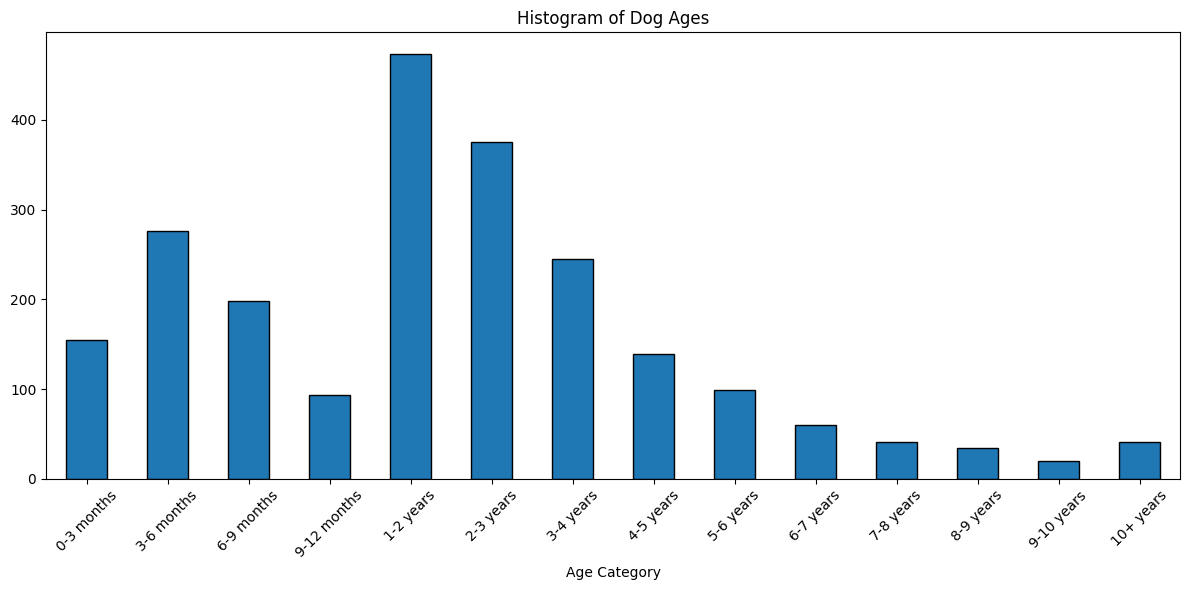

Bins: [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, inf]
Labels: ['0-49', '50-99', '100-149', '150-199', '200-249', '250-299', '300-349', '350-399', '400-449', '450-499', '500-549', '550-599', '600-649', '650-699', '700-749', '750-799', '800-849', '850-899', '900-949', '950-999', '1000+']


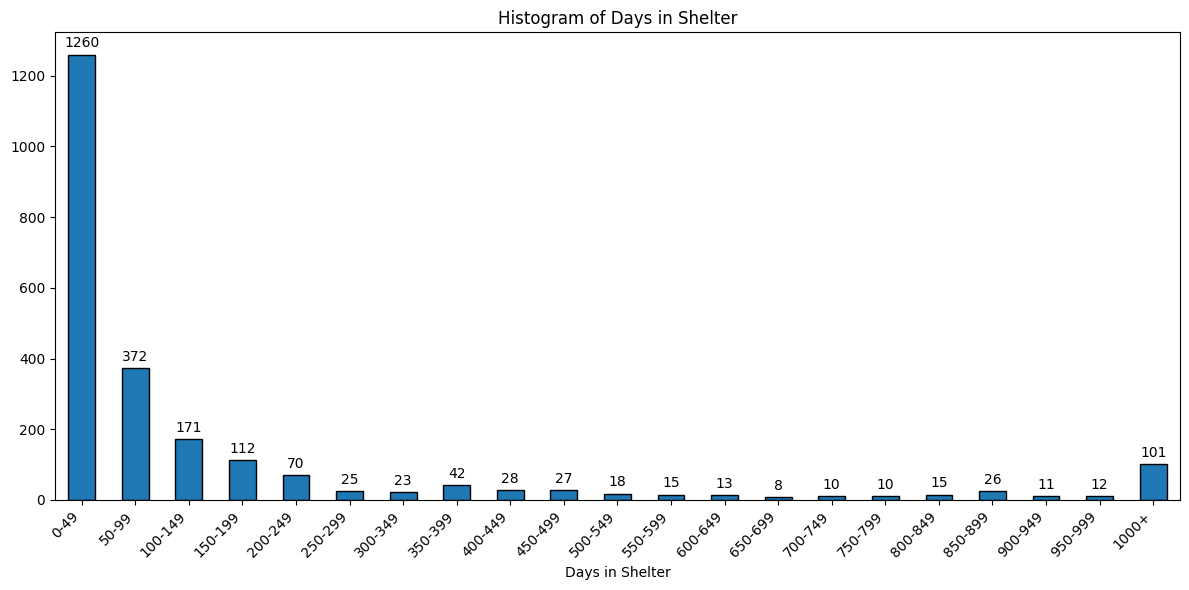

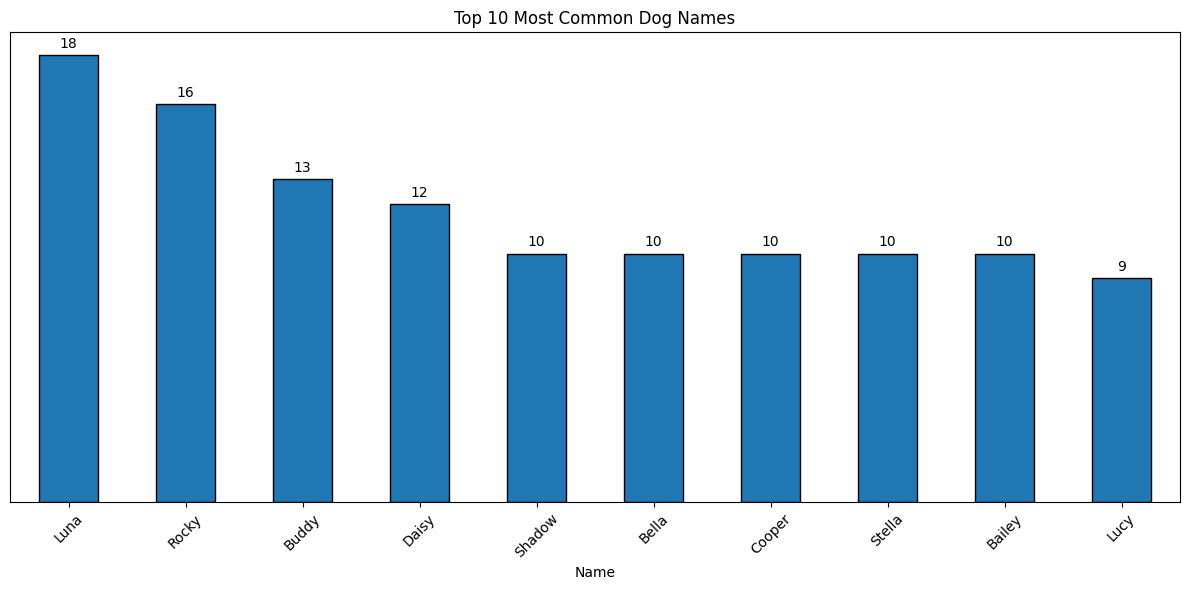

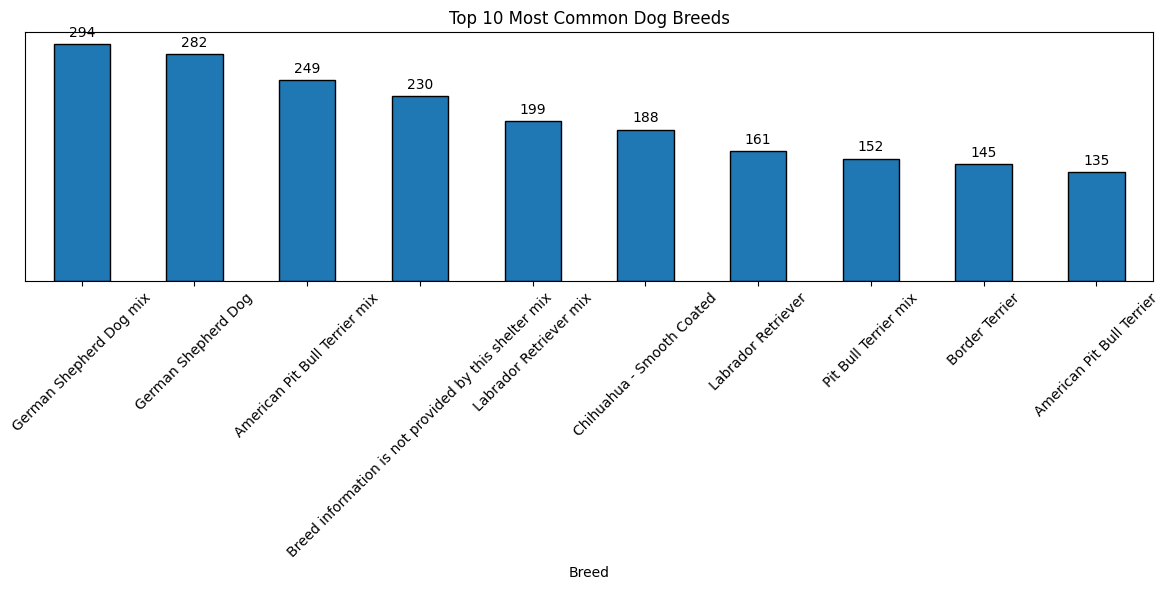

In [73]:
#ANALYSIS

# Load the cleaned data
file_path = 'all_shelters_data_clean.csv'
df = pd.read_csv(file_path)

# Convert "Age Years" to numeric, handling non-numeric values
df["Age Years"] = pd.to_numeric(df["Age Years"], errors='coerce')

# Convert "Days in Shelter" to numeric, handling non-numeric values
df["Days in Shelter"] = pd.to_numeric(df["Days in Shelter"], errors='coerce')

# Top 20 shelters with the most dogs
dogs_per_shelter = df["ShelterCode"].value_counts()
top_20_shelters = dogs_per_shelter.head(20)
print(f"Top 20 Shelters with the Most Dogs:\n{top_20_shelters}")

# Gender counts
gender_counts = df["Gender"].value_counts()
print(f"Gender Counts:\n{gender_counts}")

# Male/Female Ratio
male_count = gender_counts.get("Male", 0)
female_count = gender_counts.get("Female", 0)
male_female_ratio = male_count / female_count if female_count > 0 else "N/A"
print(f"Male/Female Ratio: {male_female_ratio}")

# Most common breeds
most_common_breeds = df["Breed"].value_counts()
print(f"Most Common Breeds:\n{most_common_breeds.head(10)}")

# Top 10 Most Common Names
top_10_names = df["Name"].value_counts().head(10)
print(f"Top 10 Most Common Names:\n{top_10_names}")

# Average Age (in years)
average_age = df["Age Years"].dropna().mean()
print(f"Average Age (in years): {average_age:.1f}")

# Average length in shelter in days
average_days_in_shelter = df["Days in Shelter"].dropna().mean()
print(f"Average Length in Shelter (days): {average_days_in_shelter:.1f}")

# Longest length in shelter in days
longest_days_in_shelter = df["Days in Shelter"].dropna().max()
print(f"Longest Length in Shelter (days): {longest_days_in_shelter}")

# Histograms

# Define bins and labels for age categories
bins = [
    0, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, float('inf')
]
labels = [
    '0-3 months', '3-6 months', '6-9 months', '9-12 months',
    '1-2 years', '2-3 years', '3-4 years', '4-5 years',
    '5-6 years', '6-7 years', '7-8 years', '8-9 years',
    '9-10 years', '10+ years'
]

# Apply binning
df["Age Bin"] = pd.cut(df["Age Years"], bins=bins, labels=labels, right=False)

# Plot histogram of dog ages
plt.figure(figsize=(12, 6))
ax = df["Age Bin"].dropna().value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Histogram of Dog Ages')
plt.xlabel('Age Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('dog_ages_histogram.jpg')
plt.show()

# Histogram of Days in Shelter
# Define bins and labels
bins = list(range(0, 1001, 50)) + [float('inf')]  # Bins up to 1000 days, then one bin for >1000 days
labels = [f'{x}-{x + 49}' for x in bins[:-2]] + ['1000+']  # Adjust labels to match bins

# Ensure bins and labels are correctly matched
print("Bins:", bins)
print("Labels:", labels)

# Assign bin labels to the 'Days in Shelter' column
df["Days in Shelter Bin"] = pd.cut(df["Days in Shelter"], bins=bins, labels=labels, right=False)

# Plot histogram of days in shelter
plt.figure(figsize=(12, 6))
ax = df["Days in Shelter Bin"].dropna().value_counts().reindex(labels).plot(kind='bar', edgecolor='black')
plt.title('Histogram of Days in Shelter')
plt.xlabel('Days in Shelter')

# Customize x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add value labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 8), textcoords='offset points')

plt.tight_layout()
plt.savefig('days_in_shelter_histogram.jpg')
plt.show()

# Histogram of Top 10 Dog Names
plt.figure(figsize=(12, 6))
ax = top_10_names.plot(kind='bar', edgecolor='black')
plt.title('Top 10 Most Common Dog Names')
plt.xlabel('Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.gca().yaxis.set_visible(False)  # Remove y-axis

# Add value labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 8), textcoords='offset points')

plt.tight_layout()
plt.savefig('top_10_dog_names_histogram.jpg')
plt.show()

# Histogram of Top 10 Dog Breeds
# Exclude 'Breed information is not provided by this shelter'
filtered_breeds = df[df["Breed"] != "Breed information is not provided by this shelter"]
top_10_breeds = filtered_breeds["Breed"].value_counts().head(10)

plt.figure(figsize=(12, 6))
ax = top_10_breeds.plot(kind='bar', edgecolor='black')
plt.title('Top 10 Most Common Dog Breeds')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.gca().yaxis.set_visible(False)  # Remove y-axis

# Add value labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 8), textcoords='offset points')

plt.tight_layout()
plt.savefig('top_10_dog_breeds_histogram.jpg')
plt.show()

In [64]:
#DOWNLOAD IMAGES
# Directory to save the images
output_folder = 'dog_images'
os.makedirs(output_folder, exist_ok=True)

# Load the data
file_path = 'all_shelters_data_clean.csv'
df = pd.read_csv(file_path)

# Function to clean URLs
def clean_url(url):
    if url.startswith("https://24petconnect.comhttps://"):
        url = url[len("https://24petconnect.com"):]
    return url

# Function to download images
def download_image(url, filename):
    try:
        # Clean URL if necessary
        url = clean_url(url)
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        
        if response.status_code == 200:
            # Check if the image is empty or if it matches the 'No_pic_t.jpg' pattern
            if 'No_pic_t.jpg' in url:
                print(f"Skipping image {filename} as it is a placeholder.")
                return

            # Check if the image is blank
            image = Image.open(BytesIO(response.content))
            if image.getbbox() is None:  # Blank image
                print(f"Skipping blank image {filename}.")
                return

            # Save the image
            with open(filename, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded {filename}")
        else:
            print(f"Failed to download {url} (Status code: {response.status_code})")
    except Exception as e:
        print(f"Error downloading {url}: {e}")

# Iterate over the URLs and download images
for index, row in df.iterrows():
    url = row['Image URL']
    filename = os.path.join(output_folder, f"image_{index}.jpg")
    download_image(url, filename)

Downloaded dog_images/image_0.jpg
Downloaded dog_images/image_1.jpg
Downloaded dog_images/image_2.jpg
Downloaded dog_images/image_3.jpg
Downloaded dog_images/image_4.jpg
Downloaded dog_images/image_5.jpg
Downloaded dog_images/image_6.jpg
Downloaded dog_images/image_7.jpg
Downloaded dog_images/image_8.jpg
Downloaded dog_images/image_9.jpg
Downloaded dog_images/image_10.jpg
Downloaded dog_images/image_11.jpg
Downloaded dog_images/image_12.jpg
Downloaded dog_images/image_13.jpg
Downloaded dog_images/image_14.jpg
Downloaded dog_images/image_15.jpg
Downloaded dog_images/image_16.jpg
Downloaded dog_images/image_17.jpg
Downloaded dog_images/image_18.jpg
Downloaded dog_images/image_19.jpg
Downloaded dog_images/image_20.jpg
Downloaded dog_images/image_21.jpg
Downloaded dog_images/image_22.jpg
Downloaded dog_images/image_23.jpg
Downloaded dog_images/image_24.jpg
Downloaded dog_images/image_25.jpg
Downloaded dog_images/image_26.jpg
Downloaded dog_images/image_27.jpg
Downloaded dog_images/image_28

In [69]:
#MAKE GIANT COLLAGE
from PIL import Image
import os

def create_collage(image_folder, collage_filename, max_image_size=(200, 200), collage_size=(4000, 4000)):
    # Load all images from the folder
    images = []
    print("Loading images...")
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(image_folder, filename)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify that it's an image
                    img = Image.open(img_path)  # Reopen the image after verification
                    images.append(img)
                    print(f"Loaded image: {filename}")
            except (IOError, SyntaxError) as e:
                print(f"Error opening image {img_path}: {e}")

    if not images:
        print("No images found to create a collage.")
        return

    # Limit the number of images to avoid overly large files
    max_images = 1000
    images = images[:max_images]
    print(f"Using {len(images)} images.")

    print(f"Resizing {len(images)} images...")
    # Resize images to fit in the collage
    resized_images = []
    for img in images:
        try:
            resized_image = img.resize(max_image_size, Image.LANCZOS)
            resized_images.append(resized_image)
        except Exception as e:
            print(f"Error resizing image: {e}")

    print("Resizing complete.")

    # Create a new blank image for the collage
    collage = Image.new('RGB', collage_size, (255, 255, 255))
    print("Creating collage...")

    # Calculate the number of images that can fit in the collage
    x_offset = 0
    y_offset = 0
    row_height = 0
    for index, img in enumerate(resized_images):
        if x_offset + img.width > collage_size[0]:
            x_offset = 0
            y_offset += row_height
            row_height = 0
        if y_offset + img.height > collage_size[1]:
            print("Collage size exceeded. Some images might not be included.")
            break
        collage.paste(img, (x_offset, y_offset))
        x_offset += img.width
        row_height = max(row_height, img.height)
        print(f"Placed image {index + 1}/{len(resized_images)} at position ({x_offset}, {y_offset})")

    # Save the collage
    collage.save(collage_filename)
    print(f"Collage saved as {collage_filename}")

# Parameters
image_folder = 'dog_images'
collage_filename = 'dog_collage_large.jpg'

# Create the collage
create_collage(image_folder, collage_filename)

Loading images...
Loaded image: image_811.jpg
Loaded image: image_3315.jpg
Loaded image: image_3473.jpg
Loaded image: image_1270.jpg
Loaded image: image_3467.jpg
Loaded image: image_805.jpg
Loaded image: image_2037.jpg
Loaded image: image_3329.jpg
Loaded image: image_193.jpg
Loaded image: image_187.jpg
Loaded image: image_2023.jpg
Loaded image: image_4452.jpg
Loaded image: image_2976.jpg
Loaded image: image_178.jpg
Loaded image: image_2962.jpg
Loaded image: image_150.jpg
Loaded image: image_3498.jpg
Loaded image: image_622.jpg
Loaded image: image_1066.jpg
Loaded image: image_3117.jpg
Loaded image: image_15.jpg
Loaded image: image_1714.jpg
Loaded image: image_3103.jpg
Loaded image: image_1072.jpg
Loaded image: image_391.jpg
Loaded image: image_29.jpg
Loaded image: image_385.jpg
Loaded image: image_408.jpg
Loaded image: image_1099.jpg
Loaded image: image_352.jpg
Loaded image: image_434.jpg
Loaded image: image_1927.jpg
Loaded image: image_420.jpg
Loaded image: image_346.jpg
Loaded image: 